In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from scipy.interpolate import InterpolatedUnivariateSpline
from sklearn.linear_model import LinearRegression

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['font.size'] = 20

rng = np.random.default_rng(11)

In [30]:
# Monte Carlo Simulator
def sim_MC(funct,
           pos_args = [],
           key_args = {},
           T = 100, 
           lamb = 1, 
           gamma = 0.5, 
           sigma = 0.3, 
           c = 0.5, 
           tau = 1/12, 
           start_pos = 1000, 
           p0 = 10, 
           n_MC = 10000):
    '''
    Runs Monte Carlo simulations with price impact for a given trading strategy funct
    '''

    J = np.zeros((n_MC, T+1)) # EWMA of past and current order flow
    I = np.zeros((n_MC, T+1)) # price impact
    X = np.zeros((n_MC, T+1)) # position (# of shares)
    W = np.zeros((n_MC, T+1)) # wealth
    alpha = np.zeros((n_MC, T+1)) # forecast
    P = np.zeros((n_MC, T+1)) # asset price
    pi = np.zeros((n_MC, T+1)) # price of buying with impact
    # Y = np.zeros(T+1) # cash position
    x = np.zeros((n_MC, T)) # quantity to trade between t and t+1

    # Initialize starting values
    P[:,0] = p0
    pi[:,0] = p0
    X[:,0] = start_pos

    key_args['tot_q'] = start_pos
    key_args['t_steps'] = T

    for i in range(T):
        if i == T-1: # if at the last time step, need to sell all shares
            x[:,i] = X[:,i]
        else:
            # determine x_t given J_{t-1}, I_{t-1}, T-t, alpha_t, X_{t-1}
            # F takes as input alpha, p ,T-t, X, input function gives execution price as function of quantity,
            # need to know decay function, alpha, how long it decays
            # x[:,i] = const_frac_F(alpha[:,i], frac, X[:,i], b)
            key_args['rem_q'] = X[:,i]
            key_args['alpha'] = alpha[:,i]
            x[:,i] = funct(*pos_args, **key_args)
            if i == 3:
                print(x[:5,i]) 

        J[:,i+1] = np.exp(-1/tau) * J[:,i] + 0.5 * x[:,i] * (1 + np.exp(-1/(2*tau)))
        I[:,i+1] = lamb * np.sign(J[:,i+1]) * abs(J[:,i+1]) ** c
        alpha[:,i+1] = np.exp(-1/tau) * alpha[:,i] + gamma * rng.standard_normal(size = n_MC)
        P[:,i+1] = P[:,i] + alpha[:,i+1] + sigma * rng.standard_normal(size = n_MC)
        pi[:,i+1] = P[:,i+1] + I[:,i+1]
        X[:,i+1] = X[:,i] - x[:,i]
        W[:,i+1] = W[:,i] + x[:,i] * pi[:,i+1] + X[:,i+1] * (P[:,i+1]-P[:,i])

    # Take mean over all MC simulations
    avg_J = np.mean(J, axis = 0)
    avg_I = np.mean(I, axis = 0)
    avg_X = np.mean(X, axis = 0)
    avg_W = np.mean(W, axis = 0)
    avg_alpha = np.mean(alpha, axis = 0)
    avg_P = np.mean(P, axis = 0)
    avg_pi = np.mean(pi, axis = 0)
    
    data = pd.DataFrame(
        {'J': avg_J,'I': avg_I, 'alpha': avg_alpha, 'P': avg_P, 'pi': avg_pi, 'X': avg_X, 'W': avg_W}
    )

    return data

# Plotter
def plot_results(f_title, df, save_fig = False, fpath = ""):
    '''
    Plot averages of MC sim with option to save fig
    '''
    
    # Create a figure and axis
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 16))

    # Columns to plot
    cols = ['J', 'I', 'X', 'W', 'alpha', 'P', 'pi']
    ylabs = ["Order Flow", "Price Impact", "# of Shares", "Wealth ($)", "Forecast", "Price ($)"]
    titles = ["EWMA of Cumulative Order Flow (J)", "Price Impact (I)", "Position (X)", "Wealth (W)", "Forecast (alpha)", "Asset Price"]

    for i, c in enumerate(cols):
        if c == 'pi':
            axes[(i-1)%3, (i-1)//3].plot(df[c], ".-", label = "With Impact")
            axes[(i-1)%3, (i-1)//3].legend()
            break
        if c == 'P':
            axes[i%3, i//3].plot(df[c], ".-", label = "No Impact")
        else:
            axes[i%3, i//3].plot(df[c], ".-")
        
        axes[i%3, i//3].set_xlabel("Time")
        axes[i%3, i//3].set_ylabel(ylabs[i])
        axes[i%3, i//3].set_title(titles[i])

    fig.suptitle(f"{f_title}", fontsize=24, fontweight = "heavy")

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Adjust layout to prevent clipping of titles
    plt.subplots_adjust(top=0.9, wspace=0.3, hspace=0.5)

    # Save figure
    if save_fig:
        fig.savefig(fpath, bbox_inches='tight')
    return fig


def plot_multi_results(f_title, df, save_fig=False, fpath=""):
    '''
    Plot averages of multidimensional MC sim with option to save fig
    data is a dict
    '''

    # Create a figure and axis
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 16))

    # Columns to plot
    cols = ['J', 'I', 'X', 'W', 'alpha', 'P', 'pi']
    ylabs = ["Order Flow", "Price Impact", "# of Shares", "Wealth ($)", "Forecast", "Price ($)"]
    titles = ["EWMA of Cumulative Order Flow (J)", "Price Impact (I)", "Position (X)", "Wealth (W)", "Forecast (alpha)", "Asset Price"]

    for i, c in enumerate(cols):
        for p in df.keys():
            if c == 'pi':
                axes[(i-1) % 3, (i-1) // 3].plot(df[p][c], ".-", label=f"With Impact, p={p}")
                axes[(i-1) % 3, (i-1) // 3].legend(fontsize='small', ncol = 2)  # Adjust legend font size
            elif c == 'P':
                axes[i % 3, i // 3].plot(df[p][c], ".-", label=f"No Impact, p={p}")
                axes[i % 3, i // 3].legend(fontsize='small', ncol = 2)  # Adjust legend font size
            else:
                axes[i % 3, i // 3].plot(df[p][c], ".-", label=f"p={p}")
                axes[i % 3, i // 3].legend(fontsize='small', ncol = 2)  # Adjust legend font size
        if c != 'pi':
            axes[i % 3, i // 3].set_xlabel("Time")
            axes[i % 3, i // 3].set_ylabel(ylabs[i])
            axes[i % 3, i // 3].set_title(titles[i])

    fig.suptitle(f"{f_title}", fontsize=24, fontweight="heavy")

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Adjust layout to prevent clipping of titles
    plt.subplots_adjust(top=0.9, wspace=0.3, hspace=0.5)

    # Save figure
    if save_fig:
        fig.savefig(fpath, bbox_inches='tight')

    return fig

In [8]:

    
def const_frac_alpha(frac, b, rem_q, alpha, **kwargs):
    assert 0 < frac < 1
    return frac * rem_q - b * alpha # when selling


## Constant x {-}

[10. 10. 10. 10. 10.]


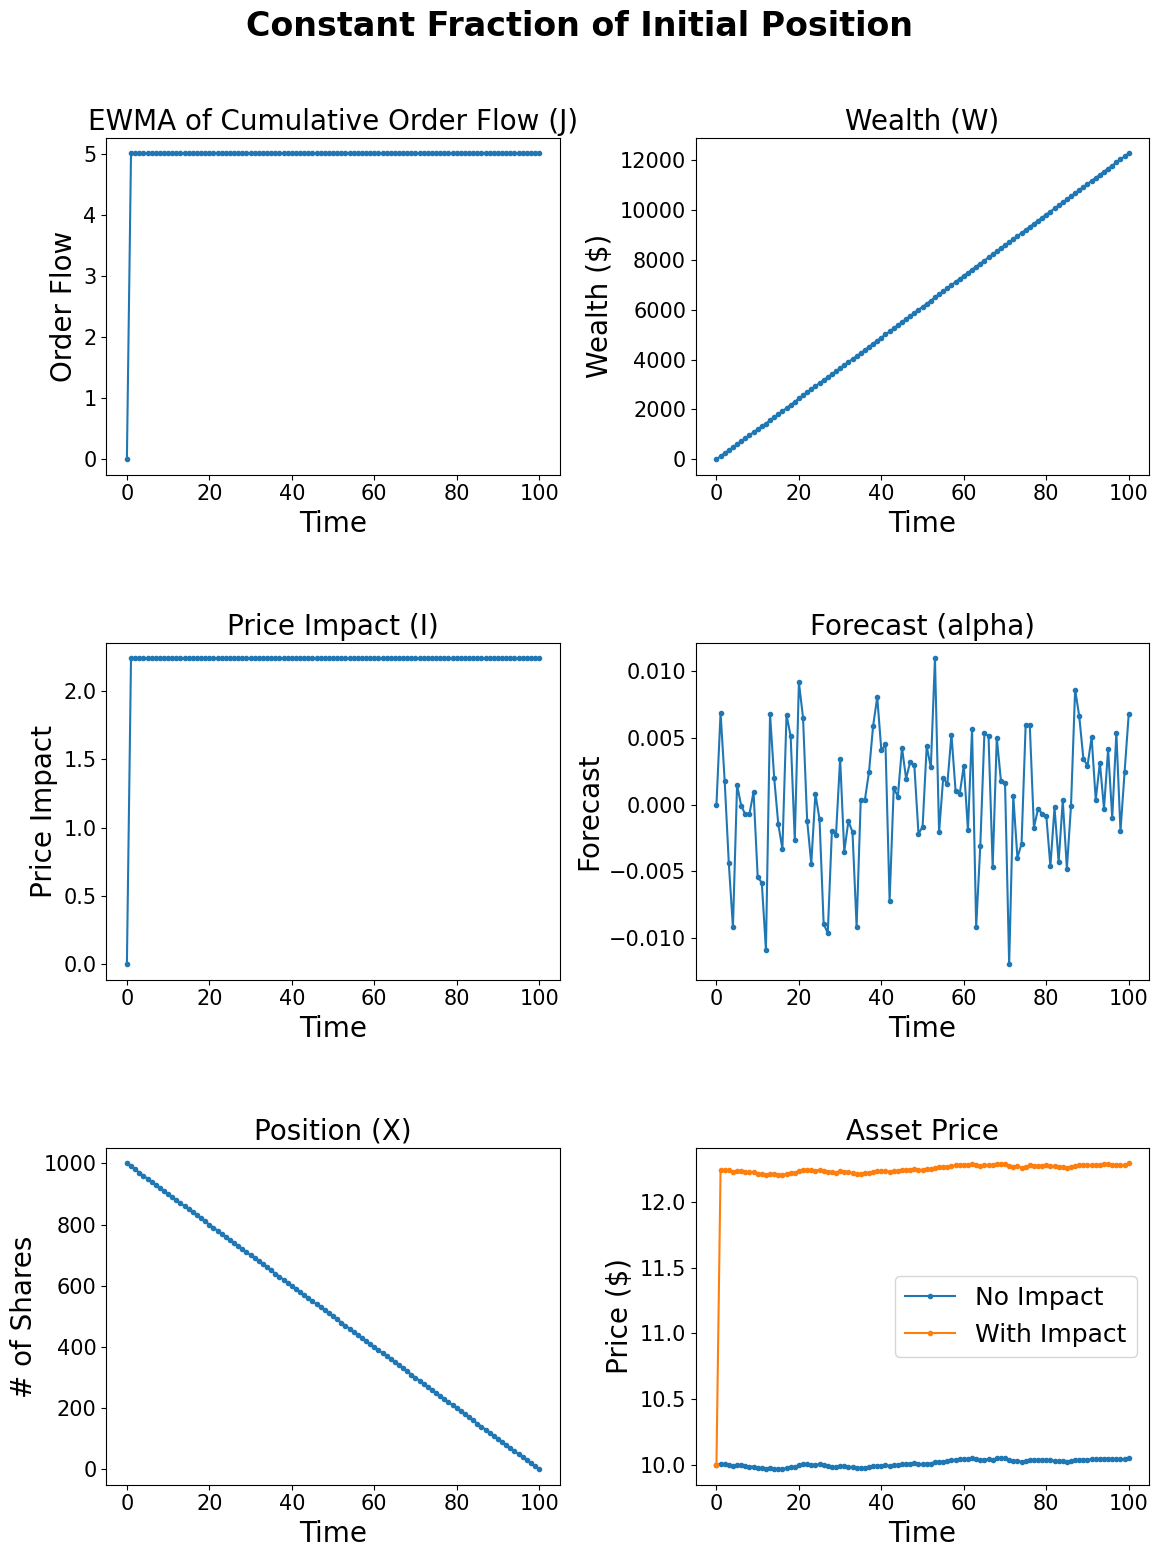

In [16]:
def const_x(tot_q, t_steps, **kwargs):
    '''
    Calculates number of shares to sell at each time step so that it's constant throughout the entire trading period from initial position and number of time steps
    '''
    assert 0 < t_steps
    return tot_q/t_steps

df = sim_MC(const_x)
plt.show(plot_results("Constant Fraction of Initial Position", df))

## Constant Fraction of Remaining Shares {-}

[72.9 72.9 72.9 72.9 72.9]
[102.4 102.4 102.4 102.4 102.4]
[102.9 102.9 102.9 102.9 102.9]
[86.4 86.4 86.4 86.4 86.4]
[62.5 62.5 62.5 62.5 62.5]
[38.4 38.4 38.4 38.4 38.4]
[18.9 18.9 18.9 18.9 18.9]
[6.4 6.4 6.4 6.4 6.4]
[0.9 0.9 0.9 0.9 0.9]


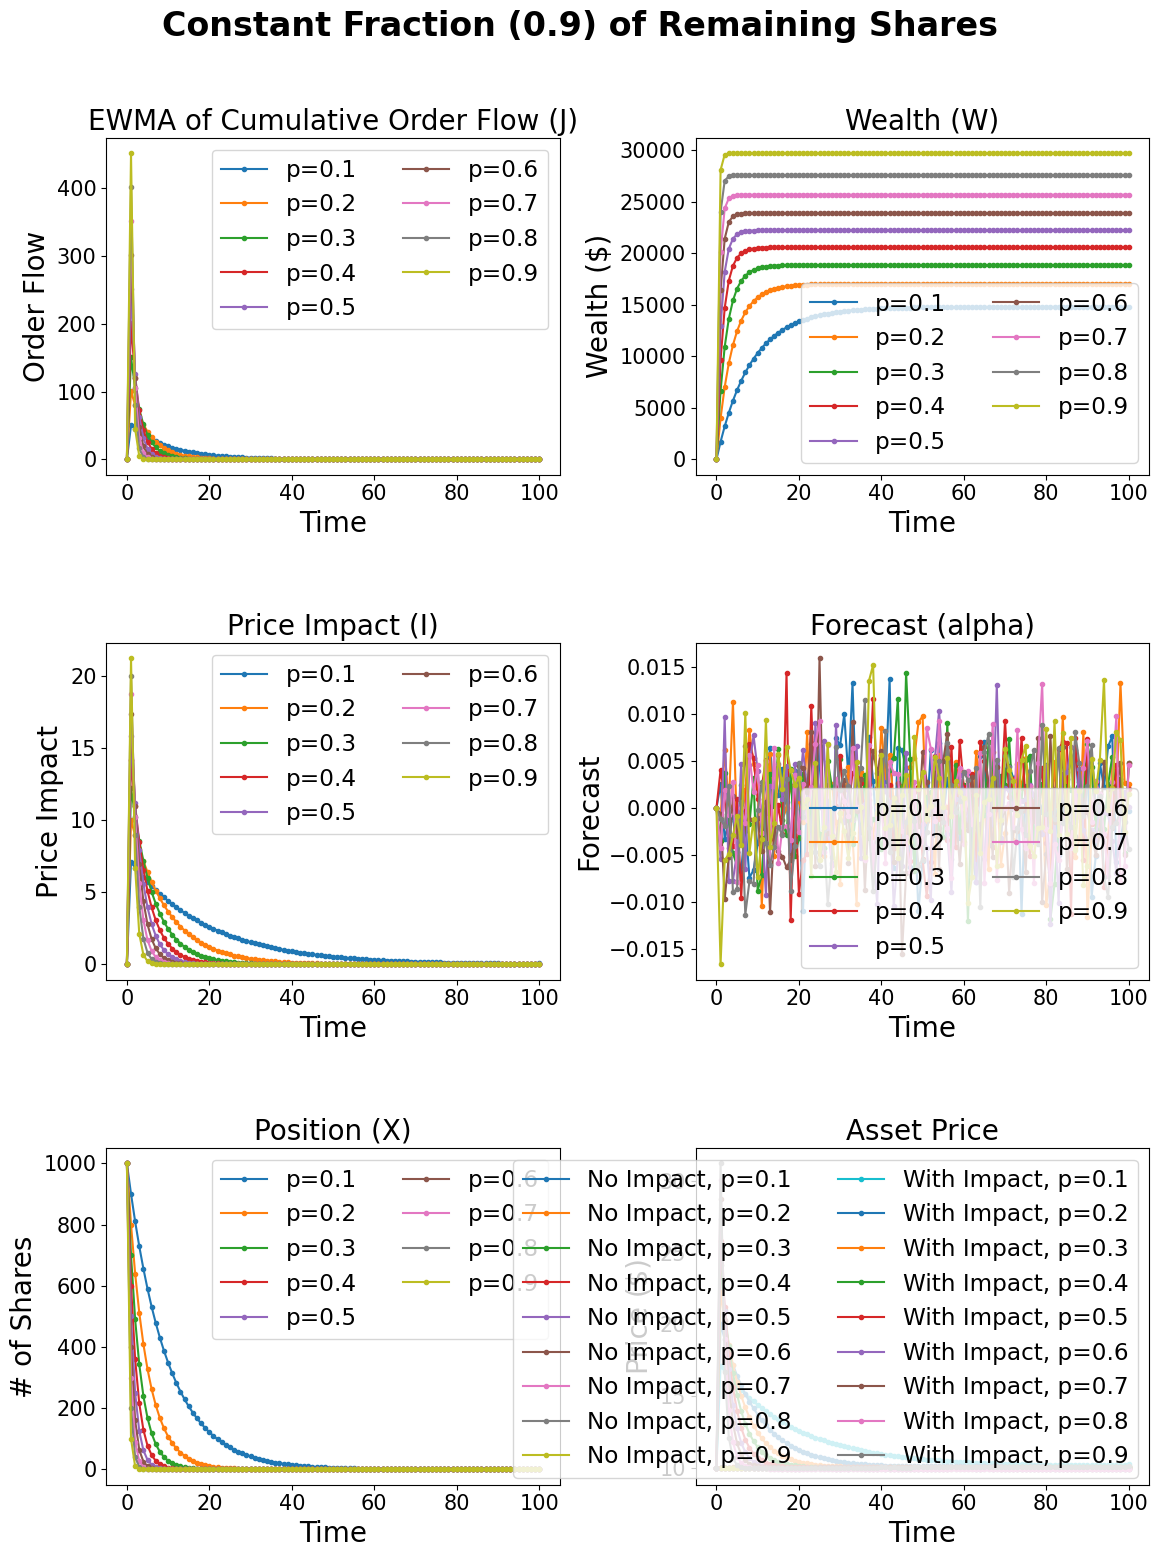

In [31]:
def const_frac(frac, rem_q, **kwargs):
    '''
    Calculates the number of shares to sell so that it's a constant fraction of the remaining shares
    '''
    assert 0 < frac < 1
    return frac * rem_q

const_frac_rem = pd.DataFrame()

d = {}

for i in range(1, 10):
    frac = i / 10

    d[frac] = sim_MC(const_frac, key_args = {'frac': frac})
plt.show(plot_multi_results(f"Constant Fraction of Remaining Shares", d))

## Linear Function of Alpha {-}

## Decreasing Function {-}

Constant Fraction of Remaining Shares

NameError: name 'T' is not defined